In [1]:
from lightgbm import LGBMClassifier
import lightgbm
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import pickle

from sklearn.metrics import confusion_matrix,f1_score,roc_auc_score,roc_curve
import matplotlib.pyplot as plt

from tqdm import tqdm 
from collections import Counter
%matplotlib inline

/Users/shunling/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# Feature Engineering

In [2]:
df = pd.read_csv('Processed_data/feature_engineered.csv',index_col=0)

In [3]:
df.head()

,claim_id,enrollee_id,enrollee_cum_claim_count,enrollee_cum_claim_amount,provider_id,hmo_id,care_id,diagnosis_id,qty,amount,unit_price,tariffs,create_m,vetted_m,label
0,10.0,89.0,1,1816.08,1.0,1.0,586.0,9.0,6.0,1816.08,302.68,302.68,3,5,0
1,11.0,89.0,2,3632.16,1.0,1.0,586.0,15925.0,6.0,1816.08,302.68,302.68,3,5,0
2,13.0,74.0,1,115.00,1.0,1.0,434.0,4342.0,5.0,115.00,23.00,23.00,3,5,0
3,13.0,74.0,2,1380.00,1.0,1.0,1102.0,4342.0,10.0,1265.00,126.50,126.50,3,5,0
4,13.0,74.0,3,1518.00,1.0,1.0,299.0,4342.0,15.0,138.00,9.20,9.20,3,5,0


In [3]:
df['tariffs'] = df['tariffs'].fillna(0)

In [4]:
df.dropna(inplace=True)

In [5]:
# training and testing data
y = df['label']
X = df.drop(columns=['claim_id','enrollee_id','vetted_m','label'])


In [10]:
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,random_state=0,test_size=0.2)

In [11]:
# tranform value of each feature according to their probability in two types of groups
def prob_transform(col,df,labels): # A is the column value array
    counts = {}
    value = {} # normalized value in total
    total = {} # total claim items each feature pair
    dif = {} # diference between false claim (1) and legal claim (0)
    
    for i,label in zip(df[col],labels):
        if i in counts:
            if label:
                counts[i][1] += 1
            else:
                counts[i][0] += 1
        else:
            if label:
                counts[i] = {1:1,0:0}
            else:
                counts[i] = {1:0,0:1}
        total[i] = counts[i][1] + counts[i][0]
        dif[i] = counts[i][1] - counts[i][0]
        value[i] = dif[i]/total[i]
        
    prob_dif = []
    for loc in range(df.shape[0]):
        v = df[col].iloc[loc] # each row value of target column
        prob_dif.append(value[v]) # imputate the value to its probability in 
        
    return prob_dif

In [12]:
for col in tqdm(X.columns):
    Xtrain[col] = prob_transform(col,Xtrain,ytrain)

  0%|          | 0/11 [00:00<?, ?it/s]/Users/shunling/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████| 11/11 [01:22<00:00,  7.47s/it]


In [14]:
Xtrain.head()

,enrollee_cum_claim_count,enrollee_cum_claim_amount,provider_id,hmo_id,care_id,diagnosis_id,qty,amount,unit_price,tariffs,create_m
652088,-0.935657,1.000000,-0.730042,-0.914951,-0.895044,-0.898870,-0.924615,-0.894549,-0.883454,-0.891726,-0.836194
634079,-0.918791,-1.000000,-0.756679,-0.914951,-1.000000,-0.882548,-0.924433,-0.929750,-0.916982,-0.927192,-0.897087
260284,-0.916866,-1.000000,-0.935940,-0.914951,-0.988571,-0.939440,-0.890627,-0.925671,-0.863585,-0.856610,-0.941105
209538,-0.905313,-0.333333,-0.942508,-0.914951,-0.868996,-0.936244,-0.924615,-0.905929,-0.913715,-0.922789,-0.938208
634881,-0.961165,0.000000,-0.960444,-0.914951,-1.000000,-0.979296,-0.910280,-0.930367,-0.883454,-0.891726,-0.897087


In [18]:
# Calculate probability difference between 

def NorCount(col1,col2,df,labels):
    counts = {}
    value = {} # normalized value in total
    total = {} # total claim items each feature pair
    dif = {} # diference between false claim (1) and legal claim (0)
    
    for x,y,label in zip(df[col1],df[col2],labels):
        if (x,y) in counts:
            if label:
                counts[(x,y)][1] += 1
            else:
                counts[(x,y)][0] += 1
        else:
            if label:
                counts[(x,y)] = {1:1,0:0}
            else:
                counts[(x,y)] = {1:0,0:1}
        
        # normalized to total counts of each feature pair
    
        total[(x,y)] = counts[(x,y)][1] + counts[(x,y)][0]
        dif[(x,y)] = counts[(x,y)][1] - counts[(x,y)][0] # positive is associated with false claim    
        value[(x,y)] = dif[(x,y)]/total[(x,y)]
        
    return value,total,dif

In [16]:
columns = ['enrollee_cum_claim_count', 'enrollee_cum_claim_amount', 'provider_id',
       'care_id', 'diagnosis_id', 'qty', 'amount', 'unit_price',
       'tariffs', 'create_m']

In [20]:
for i in tqdm(range(len(columns))):
    col1 = columns[i]
    for col2 in columns[i+1:]:
        probdif = []
        value,total,dif = NorCount(col1,col2,Xtrain,ytrain)
        
        for x,y in zip(Xtrain[col1],Xtrain[col2]):
            probdif.append(value[(x,y)])
            
        Xtrain[(col1,col2)] = probdif

  0%|          | 0/10 [00:00<?, ?it/s]/Users/shunling/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
100%|██████████| 10/10 [01:42<00:00, 10.30s/it]


In [42]:
Xtrain.head()

,enrollee_cum_claim_count,enrollee_cum_claim_amount,provider_id,hmo_id,care_id,diagnosis_id,qty,amount,unit_price,tariffs,...,"(qty, amount)","(qty, unit_price)","(qty, tariffs)","(qty, create_m)","(amount, unit_price)","(amount, tariffs)","(amount, create_m)","(unit_price, tariffs)","(unit_price, create_m)","(tariffs, create_m)"
0,-0.892271,-1.000000,-0.746835,-0.914932,-1.000000,-0.914766,-0.931920,-1.000000,-0.976331,-0.975155,...,-1.000000,-1.000000,-1.000000,-0.954198,-1.000000,-1.000000,-1.0,-0.975155,-1.0,-1.0
1,-0.897805,-1.000000,-0.746835,-0.914932,-1.000000,-1.000000,-0.931920,-1.000000,-0.976331,-0.975155,...,-1.000000,-1.000000,-1.000000,-0.954198,-1.000000,-1.000000,-1.0,-0.975155,-1.0,-1.0
2,-0.892271,-0.833333,-0.746835,-0.914932,-1.000000,-1.000000,-0.895253,-0.838710,-0.921739,-0.915094,...,-1.000000,-1.000000,-1.000000,-0.993092,-1.000000,-1.000000,-1.0,-0.924171,-1.0,-1.0
3,-0.897805,-0.739130,-0.746835,-0.914932,-0.714286,-1.000000,-0.922073,-0.913793,-0.890625,-0.872000,...,-0.866667,-0.866667,-0.833333,-0.904278,-0.866667,-0.864407,-1.0,-0.887097,-1.0,-1.0
4,-0.899106,-1.000000,-0.746835,-0.914932,-1.000000,-1.000000,-0.904683,-0.806452,-0.660377,-0.660377,...,-0.636364,-0.636364,-0.636364,-0.965049,-0.636364,-0.636364,-1.0,-0.660377,-1.0,-1.0


In [43]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 744861 entries, 0 to 744869
Data columns (total 56 columns):
enrollee_cum_claim_count                                 744861 non-null float64
enrollee_cum_claim_amount                                744861 non-null float64
provider_id                                              744861 non-null float64
hmo_id                                                   744861 non-null float64
care_id                                                  744861 non-null float64
diagnosis_id                                             744861 non-null float64
qty                                                      744861 non-null float64
amount                                                   744861 non-null float64
unit_price                                               744861 non-null float64
tariffs                                                  744861 non-null float64
create_m                                                 744861 non-null float6

# Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression

In [22]:
cls = LogisticRegression(class_weight='balanced')

In [23]:
cls.fit(Xtrain,ytrain)

/Users/shunling/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [25]:
confusion_matrix(ytrain,cls.predict(Xtrain))

array([[568552,   1965],
       [   144,  25227]])

In [29]:
roc_auc_score(ytrain,cls.predict(Xtrain)),f1_score(ytrain,cls.predict(Xtrain))

(0.9954399920094383, 0.9598767193653331)

# Random Forest

In [64]:
from sklearn.ensemble import RandomForestClassifier

In [69]:
rdf = RandomForestClassifier(n_estimators=100, max_depth=20, 
                             min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                             max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, 
                             min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=4, 
                             random_state=None, verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None)

In [70]:
rdf.fit(Xtrain,ytrain)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [71]:
f1_score(ytrain,rdf.predict(Xtrain)),f1_score(ytest,rdf.predict(Xtest))

(0.9996452223273415, 0.9969993682880607)

In [75]:
confusion_matrix(ytrain,rdf.predict(Xtrain))

array([[570511,      6],
       [    12,  25359]])

In [74]:
confusion_matrix(ytest,rdf.predict(Xtest))

array([[142622,      3],
       [    35,   6313]])

In [85]:
importance = {}
for feature,score in zip(X.columns,rdf.feature_importances_):
     importance[feature] = round(score,5)

In [99]:
importance_feature = sorted(importance, key=importance.__getitem__, reverse=True)

In [102]:

sorted_score = [importance[k] for k in importance_feature]

AttributeError: 'AxesSubplot' object has no attribute 'x_ticks'

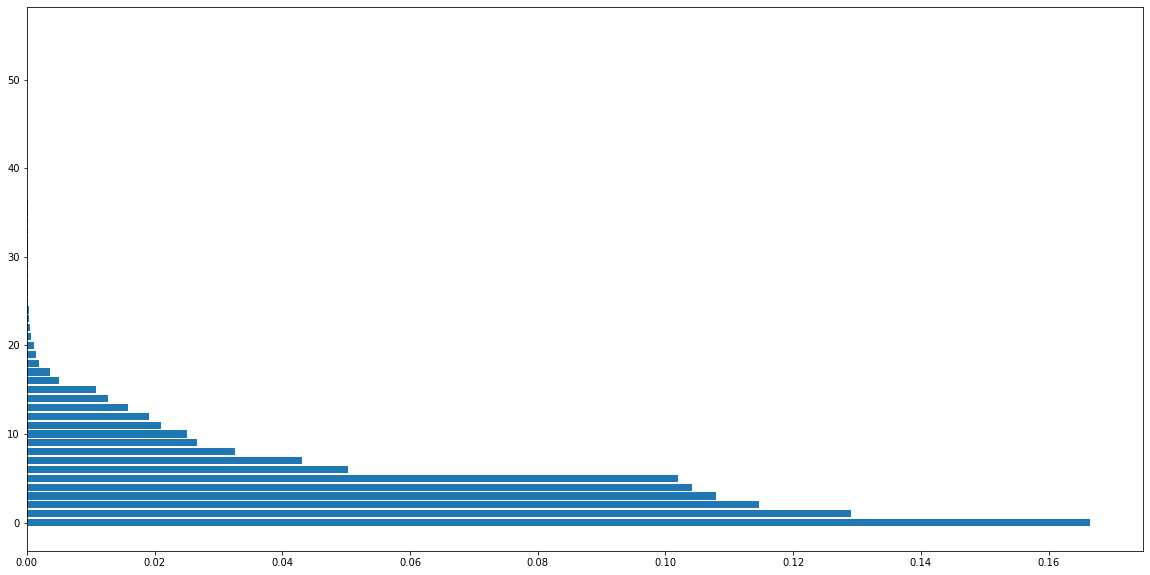

In [113]:
fig, ax = plt.subplots(figsize = (20,10))
ax.barh(range(X.shape[1]),sorted_score)
ax.x_ticks(np.arange(X.shape[1]),importance_feature)